In [36]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from functools import partial
import sys
sys.path.insert(0, '..')
import harmonic as hm
sys.path.append("../examples")
import utils

So the idea for these examples are purely explanatory so we use the f(x) analytical function of the Himmelblua function (in lin space) as the output for our loglikelihood. However, we actually invert it and return -f(x) so that these minima become maxima to make more sensible likelihood distributions.

In [38]:
def ln_likelihood(x):
    """
    Compute log_e of likelihood defined by Himmelblau function.
    Args: 
        - x: 
            Position at which to evaluate likelihood.
    Returns:
        - double: 
            Value of Himmelblau function at specified point.
    """
    
    f = (x[0]**2 + x[1] - 11.0)**2 + (x[0] + x[1]**2 - 7.0)**2


    return -f

In [39]:
def ln_prior_uniform(x, xmin=-6.0, xmax=6.0, ymin=-6.0, ymax=6.0):
    """Compute log_e of uniform prior.
    
    Args: 
    
        x: Position at which to evaluate prior.
        
        xmin: Uniform prior minimum x edge (first dimension).
        
        xmax: Uniform prior maximum x edge (first dimension).
        
        ymin: Uniform prior minimum y edge (second dimension).
        
        ymax: Uniform prior maximum y edge (second dimension).
        
    Returns:
    
        double: Value of prior at specified point.
        
    """
        
    if x[0] >= xmin and x[0] <= xmax and x[1] >= ymin and x[1] <= ymax:        
        return 1.0 / ( (xmax - xmin) * (ymax - ymin) )
    else:
        return 0.0

In [40]:
def ln_posterior(x, ln_prior):
    """Compute log_e of posterior.
    
    Args: 
    
        x: Position at which to evaluate posterior.
        
        a: First parameter of Rosenbrock function.
        
        b: First parameter of Rosenbrock function.
        
        ln_prior: Prior function.
        
    Returns:
    
        double: Posterior at specified point.
        
    """
    
    ln_L = ln_likelihood(x)

    if not np.isfinite(ln_L):
        return -np.inf
    else:
        return ln_prior(x) + ln_L

In [41]:
# Define parameters for emcee sampling
ndim = 2                    # number of dimensions
nchains = 200               # total number of chains to compute
samples_per_chain = 5000    # number of samples per chain
nburn = 2000                # number of samples to discard as burn in

# Initialize random seed
np.random.seed(2)

# Define ln_prior function
xmin = -5.0
xmax = 5.0
ymin = -5.0
ymax = 5.0  
ln_prior = partial(ln_prior_uniform, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)  

In [42]:
# Set initial random position and state
pos = np.random.rand(ndim * nchains).reshape((nchains, ndim)) * 0.1   
rstate = np.random.get_state()

# Instantiate and execute sampler 
sampler = emcee.EnsembleSampler(nchains, ndim, ln_posterior, args=[ln_prior])
(pos, prob, state) = sampler.run_mcmc(pos, samples_per_chain, rstate0=rstate) 

# Collect samples into contiguous numpy arrays (discarding burn in)
samples = np.ascontiguousarray(sampler.chain[:,nburn:,:])
lnprob = np.ascontiguousarray(sampler.lnprobability[:,nburn:])

In [43]:
ln_posterior_func = partial(ln_posterior, ln_prior=ln_prior)
ln_posterior_grid, x_grid, y_grid = utils.eval_func_on_grid(
                                        ln_posterior_func, 
                                        xmin=xmin, xmax=xmax, 
                                        ymin=ymin, ymax=ymax, 
                                        nx=1000, ny=1000)
dx = x_grid[0,1] - x_grid[0,0]
dy = y_grid[1,0] - y_grid[0,0]

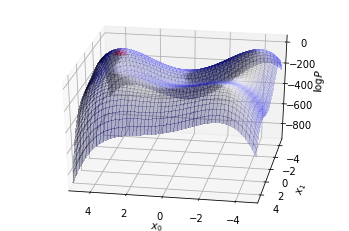

In [44]:
ax = utils.plot_surface(ln_posterior_grid, x_grid, y_grid, 
                        samples[0,:,:].reshape((-1, ndim)), 
                        lnprob[0,:].reshape((-1, 1)))              
ax.set_zlabel(r'$\log P$')
ax.view_init(30,100)
plt.show(block=False)  

In [45]:
# utils.plot_getdist(samples.reshape((-1, ndim)))